In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
print(os.getcwd())
os.chdir("../")

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Python_Backend/Backend/experiments


In [3]:
import os
print(os.getcwd())
os.chdir("../")

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Python_Backend/Backend


In [4]:
print(os.getcwd())

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Python_Backend


In [ ]:
import uvicorn

# Run your FastAPI app in the notebook process
# This will block, so best to run in a thread
import threading
from App.main import app

def run_app():
    uvicorn.run(app, host="127.0.0.1", port=8000)

thread = threading.Thread(target=run_app, daemon=True)
thread.start()

/opt/anaconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO:     Started server process [81996]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


In [9]:
import httpx
from sseclient import SSEClient

url = "http://127.0.0.1:8000/chat/stream"
payload = {"user_input": "Tell me about cappuccino", "user_id": 3}

with httpx.stream("POST", url, json=payload, timeout=None) as response:
    client = SSEClient(response.iter_raw())
    for event in client.events():
        print("Chunk:", event.data)

Chunk: Hi
Chunk:  Pand
Chunk: hari
Chunk: ,
Chunk:  I
Chunk: 'd
Chunk:  be
Chunk:  happy
Chunk:  to
Chunk:  tell
Chunk:  you
Chunk:  about
Chunk:  our
Chunk:  c
Chunk: app
Chunk: ucc
Chunk: ino
Chunk: .
Chunk:  It
Chunk: 's
Chunk:  a
Chunk:  rich
Chunk:  and
Chunk:  creamy
Chunk:  drink
Chunk:  made
Chunk:  with
Chunk:  freshly
Chunk:  brewed
Chunk:  espresso
Chunk: ,
Chunk:  ste
Chunk: amed
Chunk:  milk
Chunk: ,
Chunk:  and
Chunk:  a
Chunk:  fro
Chunk: thy
Chunk:  milk
Chunk:  cap
Chunk: .
Chunk:  Our
Chunk:  c
Chunk: app
Chunk: ucc
Chunk: ino
Chunk:  offers
Chunk:  a
Chunk:  perfect
Chunk:  balance
Chunk:  of
Chunk:  bold
Chunk:  coffee
Chunk:  flavor
Chunk:  and
Chunk:  smooth
Chunk:  milk
Chunk: ,
Chunk:  making
Chunk:  it
Chunk:  an
Chunk:  ideal
Chunk:  companion
Chunk:  for
Chunk:  relaxing
Chunk:  mornings
Chunk:  or
Chunk:  lively
Chunk:  conversations
Chunk: .
Chunk:  The
Chunk:  price
Chunk:  of
Chunk:  our
Chunk:  c
Chunk: app
Chunk: ucc
Chunk: ino
Chunk:  is
Chunk:  $
Chun

In [6]:
from Backend.graph.coffee_shop_graph import build_coffee_shop_graph
build = build_coffee_shop_graph()

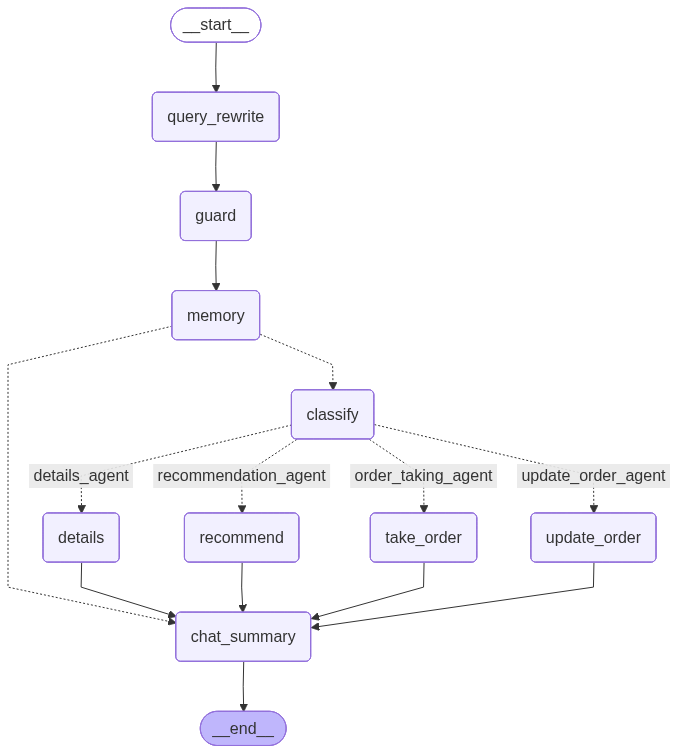

In [ ]:
from IPython.display import Image , display
display(Image(build.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from App.chatbot import get_bot_response

In [10]:
print(get_bot_response(user_input="I want to order 2 Samosa" , user_id=15))


Starting get_user_memory
Done get_user_memory
Starting get_summary
Done get_summary
Starting get_messages
Done get_messages
Starting get_order
Started Get Order
Done get_order
items=[ProductItemInput(name='Samosa', quantity=2)]
{'user_memory': UserMemory(name='Pratik', likes=[], dislikes=[], allergies=[], last_order=None, feedback=[], location=None), 'messages': [], 'chat_summary': '', 'user_input': 'I want to order 2 Samosa.', 'response_message': "\n\nTotal (for available items): $0\n\nHowever, some items that we don't serve in our coffee shop:\n❌ Samosa\nWould you like to replace them?Recommendations with this order : []", 'decision': <GuardDecisionType.allowed: 'allowed'>, 'target_agent': <AgentType.order_taking_agent: 'order_taking_agent'>, 'order': [], 'final_price': 0, 'memory_node': False}


In [ ]:
!pip show langchain_groq

In [ ]:

from Backend.utils.memory_manager import get_user_memory
from Backend.utils.summary_memory import get_summary , get_messages , get_order

graph = build_coffee_shop_graph() 

In [ ]:
import asyncio
import json
from rich import print

async def test_graph_stream(user_input: str, user_id: int):
    state = {
        "user_memory": None,
        "messages": [],
        "chat_summary": "",
        "user_input": "",
        "response_message": None,
        "decision": None,
        "target_agent": None,
        "order": [],
        "final_price": None,
        "memory_node": False,
    }

    state["user_input"] = user_input
    state["user_memory"] = get_user_memory(user_id)
    state["chat_summary"] = get_summary(id=user_id)
    state["messages"] = get_messages(id=user_id)
    state["order"], state["final_price"] = get_order(id=user_id)

    config = {
        "configurable": {
            "user_id": user_id
        }
    }

    print("[bold green]🚀 Starting graph stream...[/bold green]\n")

    async for event in graph.astream(state, config=config):
        if "node" in event:
            node = event["node"]
            print(f"[bold blue]🔧 Node running: {node}[/bold blue]")
        if "at" in event:
            print(f"[dim]🕒 {event['at']}[/dim]")

    print("\n✅ [bold green]Done.[/bold green]")

# Run it
await test_graph_stream("I want to order it", user_id=123)

In [ ]:
from typing import List, Callable, Optional, Type
from pydantic import BaseModel

def call_with_fallback(
    model_factories: List[Callable],
    prompt: str,
    schema: Optional[Type[BaseModel]] = None,
    temperature: float = 0.0,
):
    """
    Call multiple LLMs in fallback order.
    Supports both simple and structured outputs.
    
    Args:
        model_factories: List of model factory callables (lambda **kw: LLM(...))
        prompt: User input or task instruction
        schema: Optional Pydantic model for structured output
        temperature: Sampling temperature for all LLMs
    
    Returns:
        LLM response (str if schema=None, else schema instance)
    """
    last_error = None
    
    for factory in model_factories:
        try:
            llm = factory(temperature=temperature)
            
            if schema:
                # Structured output case
                structured_llm = llm.with_structured_output(schema)
                return structured_llm.invoke(prompt)
            else:
                # Simple output case
                return llm.invoke(prompt)
                
        except Exception as e:
            print(f"⚠️ {factory.__name__} failed: {e}")
            last_error = e
            continue
    
    raise RuntimeError(f"All models failed. Last error: {last_error}")